In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'1.15.0'

In [83]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

In [35]:
sess = tf.Session()

In [24]:
dataset = tf.data.Dataset.range(1,4)

In [27]:
dataset

<RangeDataset shapes: (), types: tf.int64>

In [28]:
d = tf.data.Dataset.range(4,8)

In [31]:
dataset =dataset.concatenate(d)

In [30]:
d

<RangeDataset shapes: (), types: tf.int64>

In [34]:
onedata = dataset.make_one_shot_iterator().get_next()
#onedata = d.make_one_shot_iterator().get_next()

In [35]:
num_batch = 0
while True:
    try:
        value = sess.run(onedata)
        print("Num Batch: ", num_batch)
        print("Batch value: ", value)
        #assert j == value
        #j += 1
        num_batch += 1
    except tf.errors.OutOfRangeError:
        break

Num Batch:  0
Batch value:  1
Num Batch:  1
Batch value:  2
Num Batch:  2
Batch value:  3
Num Batch:  3
Batch value:  4
Num Batch:  4
Batch value:  5
Num Batch:  5
Batch value:  6
Num Batch:  6
Batch value:  7


# 读取文本等数据

# 读取图像数据

In [54]:
target_size = (128,128)
batch_size = 5

In [55]:
def read_decode(path, label):
    img = tf.image.decode_image(tf.read_file(path), channels=3)
    img = tf.image.resize_bilinear(tf.expand_dims(img, axis=0), target_size)
    img = tf.squeeze(img, 0)
    #img = preprocess_fct(img) # should work with Tensors !

    label = tf.one_hot(label, num_classes)
    img = tf.Print(img, [path, label], 'Read_decode')
    return (img, label)

In [56]:
def get_files(dir_path, label):
    globbed = tf.string_join([dir_path, '*.jpg'])
    files = tf.matching_files(globbed)

    num_files = tf.shape(files)[0] # in the directory
    labels = tf.tile([label], [num_files, ]) # expand label to all files
    return tf.data.Dataset.from_tensor_slices((files, labels))

In [107]:
directory = 'D:/workspace/data/train_tmp'
# directory/label1/dog.1.jpg
# directory/label2/cat.1.jpg

https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/data/Dataset#interleave

In [129]:
classes = sorted(glob.glob(directory + '/*/')) # final slash selects directories only
num_classes = len(classes)

labels = np.arange(num_classes, dtype=np.int32)

 # 1 Creates a Dataset whose elements are slices of the given tensors.
dirs = tf.data.Dataset.from_tensor_slices(
        tensors=(classes, labels)  # A dataset element, with each component having the same size in the 0th dimension.
                                         ) 
files = dirs.apply(# Applies a transformation function to this dataset.
    tf.data.experimental.parallel_interleave( # Maps map_func across this dataset, and interleaves the results.
    get_files, cycle_length=num_classes, block_length=4,      # 2
    sloppy=True)) # False is important ! Otherwise it mixes labels
files = files.cache()
imgs = files.map(read_decode, num_parallel_calls=2).apply(tf.data.experimental.shuffle_and_repeat(2,1))\
            .batch(batch_size)\
            .prefetch(5)

In [130]:
imgs = imgs.shuffle(buffer_size=6)

In [136]:
imgs_iter = imgs.make_one_shot_iterator()  # Creates an Iterator for enumerating the elements of this dataset. (deprecated)
imgs_iter = imgs_iter.get_next()  # 获取下一个数据

In [137]:
num_batch = 0
while True:
    try:
        value = sess.run(imgs_iter)
        print(len(value))
        print("Num Batch: ", num_batch)
        print(value[0].shape)
        #print("Batch value: ", value)
        #assert j == value
        #j += 1
        num_batch += 1
        
        #break
    except tf.errors.OutOfRangeError:
        break

2
Num Batch:  0
(3, 128, 128, 3)
2
Num Batch:  1
(5, 128, 128, 3)
2
Num Batch:  2
(5, 128, 128, 3)


In [133]:
classes
num_classes
value[1]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

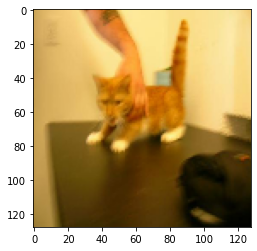

In [106]:
value
imshow(np.asarray(value[0][0]).astype(np.int32))

In [94]:
np.asarray(value[0][0]).astype(np.int32)

array([[[202, 163,  86],
        [206, 167,  90],
        [209, 170,  93],
        ...,
        [246, 208, 125],
        [244, 204, 119],
        [240, 202, 121]],

       [[202, 163,  86],
        [206, 167,  90],
        [209, 170,  93],
        ...,
        [245, 208, 127],
        [243, 205, 120],
        [241, 203, 122]],

       [[202, 163,  86],
        [206, 167,  90],
        [209, 170,  93],
        ...,
        [246, 210, 129],
        [243, 206, 125],
        [242, 204, 123]],

       ...,

       [[156, 124,  51],
        [157, 125,  52],
        [159, 127,  54],
        ...,
        [  3,   4,   0],
        [  3,   4,   0],
        [  1,   2,   0]],

       [[154, 123,  54],
        [155, 124,  55],
        [157, 127,  57],
        ...,
        [  2,   3,   0],
        [  2,   3,   0],
        [  2,   3,   0]],

       [[151, 120,  53],
        [153, 122,  55],
        [156, 125,  58],
        ...,
        [  1,   2,   0],
        [  1,   2,   0],
        [  1,   2,   0]]

In [95]:
value[0][0]

array([[[202.      , 163.      ,  86.      ],
        [206.8125  , 167.8125  ,  90.8125  ],
        [209.1875  , 170.1875  ,  93.1875  ],
        ...,
        [246.      , 208.      , 125.      ],
        [244.8125  , 204.8125  , 119.8125  ],
        [240.90625 , 202.90625 , 121.90625 ]],

       [[202.      , 163.      ,  86.      ],
        [206.8125  , 167.8125  ,  90.8125  ],
        [209.1875  , 170.1875  ,  93.1875  ],
        ...,
        [245.97803 , 208.97803 , 127.97803 ],
        [243.8125  , 205.8125  , 120.8125  ],
        [241.82812 , 203.82812 , 122.828125]],

       [[202.      , 163.      ,  86.      ],
        [206.8125  , 167.8125  ,  90.8125  ],
        [209.1875  , 170.1875  ,  93.1875  ],
        ...,
        [246.15625 , 210.84375 , 129.71875 ],
        [243.96875 , 206.8125  , 125.5     ],
        [242.90625 , 204.90625 , 123.90625 ]],

       ...,

       [[156.76562 , 124.765625,  51.765625],
        [157.97803 , 125.97803 ,  52.978027],
        [159.62207 , 1